## Constructing CS for weighted sampling without replacement 

To construct the CS, we need to specify the following terms: 
* `N`: int, denoting the total number of transactions 
* `M`: numpy array, containing the reported transaction values 
* `f`: numpy array, containing the true misspecified fractions in [0,1].
        For simplicity, we have assumed that `f` takes the form 
        of a numpy array, and it is accessed via its index when 
        needed. A more general implementation should have `f` as 
        a function handle, representing the oracle (i.e., human auditor), 
        that takes in as input an index in the range `{1, 2, ..., N}`, and 
        outputs the true misstated fraction for that index.  
*`S`: numpy array, containing the side-information in [0,1].
        This represents the predicted f-values, generated by an AI model 
        trained on historical data. 


### Generating synthetic data 
Our CS construction works for arbitrary `M, f, S` values (assuming `f` and `S` are [0,1]-valued). However, for empirically testing the performance, we have included a function `generate_MFS` for generating `M, f, S` triplets synthetically. We begin by describing how to use that function to generate the problem data.  

* **Generating `M`**: This function generates the data with `N` transactions, of which `N1` have "large values" and `N2` have small values. The precise range of these large and small values area specified in the input parameter `M_ranges`. 
* **Generating `f`**: The function takes another paramter `f_ranges` that specifies the in intervals within which `f` lies uniformly for small and large `M` values. 
* **Generating `S`**: Finally, the side-information is generated to lie within a ratio `[1-a, 1+a]` for `a` in (0,1) of the ground truth `f`-values. This is specfied by the input parameter `f_over_S_range`. 

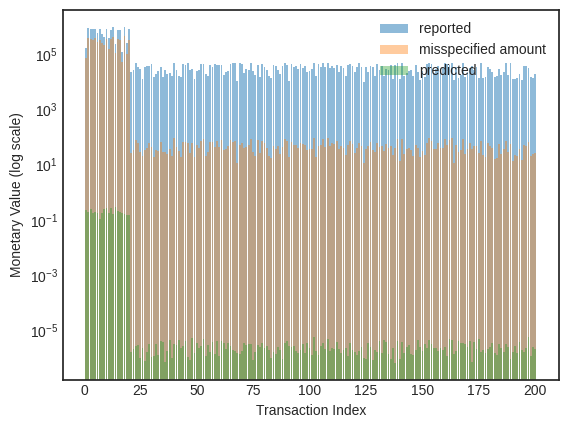

In [13]:
import numpy as np 
import matplotlib.pyplot as plt 
from utils import generate_MFS

N = 200
N1 = 20
N2 = N - N1
a = 0.4
f_over_S_range = [1 - a, 1 + a]
f_ranges = [[0.4, 0.5], [1e-3, 2 * 1e-3]]
M_ranges = [ [1e5, 1e6], [1e4, 5*1e4]]
M, f, S = generate_MFS(N_vals=(N1, N2), N=N,  M_ranges=M_ranges,f_ranges=f_ranges, a=a)


NN = np.arange(1, N+1)
plt.figure()
plt.bar(NN, M, label='reported', alpha=0.5)
plt.bar(NN, M*f, label='misspecified amount', alpha=0.4)
plt.bar(NN, S*f, label='predicted', alpha=0.4)
plt.yscale('log')
plt.ylabel('Monetary Value (log scale)')
plt.xlabel('Transaction Index')
plt.legend()



### Constructing the CSs 

To construct the CS, we mainly need to specify the following: 
* `cs`: choose between `Bet`, `Emp. Bern.`, or `Hoef.`
* `method_name`: this can be `propM`, `propMS`, or `uniform`
* `use_CV`: this is a bool, which decides whether control-variates should be used or not. Only use this option with the `proM` method. 

Below, we demonstrate how to construct betting-based CSs, using propM sampling strategy, with and without control variates

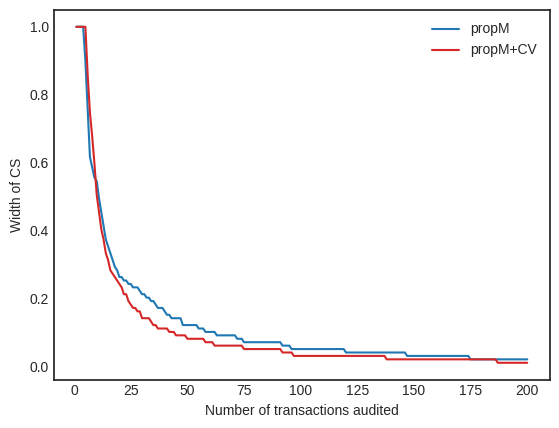

In [17]:
from weightedCSsequential import run_one_expt
from constants import ColorsDict
nG = 100
lambda_max = 1.5 
beta_max = 1.5

def func(M, f, S, nG, lambda_max, beta_max):
    result_propMS = run_one_expt(M, f, S, 
                                    cs='Bet',
                                    method_name='propM',
                                    lambda_max=lambda_max,
                                    beta_max=beta_max,
                                    nG=nG,
                                    use_CV=False,
                                    f_over_S_range=f_over_S_range,
                                    alpha=0.05,
                                    logical_CS=False,
                                    intersect=False,
                                    return_payoff=False)
    grid, _, L1, U1, _, _, _ = result_propMS


    result_CV = run_one_expt(M, f, S, 
                                cs='Bet',
                                method_name='propM',
                                lambda_max=lambda_max,
                                beta_max=beta_max,
                                nG=nG,
                                use_CV=True,
                                f_over_S_range=f_over_S_range,
                                alpha=0.05,
                                logical_CS=False,
                                intersect=False,
                                return_payoff=False)
    _, _, L2, U2, _, _, _ = result_CV
    return L1, U1, L2, U2

# call the function 
L1, U1, L2, U2 = func(M, f, S, nG, lambda_max, beta_max)
plt.figure()
plt.plot(NN, U1-L1, label='propM', color=ColorsDict['propM'])
plt.plot(NN, U2-L2, label='propM+CV', color=ColorsDict['propM+CV'])
plt.ylabel('Width of CS')
plt.xlabel('Number of transactions audited')
plt.legend()
plt.show()


Finally, note that we can also extract the first time when the CS falls below a level $\epsilon$, by calling the function `first_threshold_crossing`. By repeating this whole process several times, we can obtain the distribution of the stopping times of the two methods. 


In [20]:
from tqdm import tqdm 
from utils import first_threshold_crossing

num_trials = 100 
epsilon = 0.05 # the threshold for stopping 
# initialize the arrays to store the stopping times 
StoppingTimes_propM = np.zeros((num_trials,))
StoppingTimes_CV = np.zeros((num_trials,))
# repeat the experiment `num_trials` times to get the array of stopping times 
for trial in tqdm(range(num_trials)):
    # generate M, F, S 
    M, f, S = generate_MFS(N_vals=(N1, N2), N=N,  M_ranges=M_ranges,f_ranges=f_ranges, a=a)
    # get the L, U, values for the two methods 
    L1, U1, L2, U2 = func(M, f, S, nG, lambda_max, beta_max)
    # get the two stopping times 
    st1 = first_threshold_crossing(U1-L1, th=epsilon, upward=False)
    st2 = first_threshold_crossing(U2-L2, th=epsilon, upward=False)
    StoppingTimes_propM[trial] = st1
    StoppingTimes_CV[trial] = st2
# plot the histogram 
plt.figure()
plt.hist(x=StoppingTimes_propM, label='propM', color=ColorsDict['propM'], alpha=0.6)
plt.hist(x=StoppingTimes_CV, label='propM+CV', color=ColorsDict['propM+CV'], alpha=0.6)
plt.title("Stopping Time Distribution")
plt.ylabel("Density")
plt.xlabel("Stopping Times")
plt.legend()
plt.show()

 64%|██████▍   | 64/100 [01:33<00:53,  1.48s/it]